In [1]:
# unzip -o -qq \*.zip

In [2]:
# singularity shell heudiconv
# dcm2niix .

In [3]:
#### CONVERT DCM2NIFTI
import os

indir = '~/data/sfari/'
indir = os.path.expanduser(indir)
conts = os.listdir(indir)
conts.sort()
folders = [cont for cont in conts if os.path.isdir(os.path.join(indir,cont))  and not cont.startswith('.')]

with open('../Batch_jobs/sfari_dcm2nii.sh', 'w') as f:
    for folder in folders:
        f.write(f'dcm2niix {os.path.join(indir,folder)}\n')
        
# chmod '~/sfari_dcm2nii.sh
# ./sfari_dcm2nii.sh

In [41]:
import pandas as pd
import os
import numpy as np
import ants
from tqdm import tqdm
import shutil
import nibabel as nib


In [5]:
def safe_mkdir(dir_path):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

In [6]:
indir = '~/data/sfari/'
outdir = '~/data/sfari_bids/'

indir = os.path.expanduser(indir)
outdir = os.path.expanduser(outdir)
safe_mkdir(outdir)

In [7]:
df_sfari = pd.DataFrame()

In [8]:
session = 'FCAP1'
use_folders = [folder for folder in folders if folder.endswith(session)]
print(len(use_folders))
use_folders[0:5]

208


['14702.x3_60_FCAP1',
 '14703.x3_50_FCAP1',
 '14705.x14_50_FCAP1',
 '14708.x10_60_FCAP1',
 '14713.x7_50_FCAP1']

In [9]:
sfari_ids = [use_folder.split('_')[0] for use_folder in use_folders]
site_ids = [use_folder.split('_')[1] for use_folder in use_folders]
bids_names = np.array([f'sub-{i:03d}' for i in range(1,len(sfari_ids)+1)])

In [10]:
df_sfari['sfari_ids'] = sfari_ids
df_sfari['site_ids'] = site_ids
df_sfari['subID'] = bids_names

In [11]:
df_sfari.head()

,sfari_ids,site_ids,subID
0,14702.x3,60,sub-001
1,14703.x3,50,sub-002
2,14705.x14,50,sub-003
3,14708.x10,60,sub-004
4,14713.x7,50,sub-005


In [12]:
df_sfari.shape[0]

208

In [13]:
unique_sites = df_sfari['site_ids'].unique()
unique_sites

array(['60', '50'], dtype=object)

In [45]:
ss = 0
site = unique_sites[ss]
safe_mkdir(os.path.join(outdir,f'ds-sfari-{site}'))
site_subs = df_sfari['sfari_ids'].values[df_sfari['site_ids'].values==site]
site_subIDs = df_sfari['subID'].values[df_sfari['site_ids'].values==site]
nsite = len(site_subs)
print()
for s in tqdm(range(0,1)):
    sub = site_subs[s]
    subID = site_subIDs[s]
    sub_dir = os.path.join(indir,f'{sub}_{site}_{session}')
    sub_files = os.listdir(sub_dir)
    sub_files.sort()

    niis = [sub_file for sub_file in sub_files if sub_file.endswith('.nii')]

    anat_scan = [scan_name for scan_name in niis if all((scan_name.startswith(sub), 'mgh_multiecho_3D_1mm_iso_MGHprotocol' in scan_name, scan_name.endswith('_e1.nii'))) or all((scan_name.startswith(sub),'MEMPRAGE' in scan_name,scan_name.endswith('e1.nii')))]
    if type(anat_scan)==list and len(anat_scan)>1:
        anat_scan = [anat_scan[-1]]
        
    func_scans = [scan_name for scan_name in niis if scan_name.startswith(sub) and 'resting' in scan_name.lower() and scan_name.endswith('.nii')]
    
    
    safe_mkdir(os.path.join(outdir,f'ds-sfari-{site}',subID))
    safe_mkdir(os.path.join(outdir,f'ds-sfari-{site}',subID,'anat'))
    safe_mkdir(os.path.join(outdir,f'ds-sfari-{site}',subID,'func'))
    

    anat_in = os.path.join(sub_dir,anat_scan[0])
    anat_out = os.path.join(outdir,f'ds-sfari-{site}',subID,'anat',f'{subID}_T1w.nii.gz')
    if not os.path.exists(anat_out):
        anat_im = ants.image_read(anat_in)
        anat_im.to_filename(anat_out)
        shutil.copyfile(src=anat_in.replace('.nii','.json'), dst=anat_out.replace('.nii.gz','.json'))

    for idx,func_scan in enumerate(func_scans):
        func_in = os.path.join(sub_dir,func_scan)
        func_out = os.path.join(outdir,f'ds-sfari-{site}',subID,'func',f'{subID}_task-rest_run-{idx+1}_bold.nii.gz')
        
        if not os.path.exists(func_out):
            func_im = ants.image_read(func_in)
            func_im.to_filename(func_out)
            
            im = nib.load(func_out)
            header = im.header.copy()
            header.set_xyzt_units(xyz='mm', t='sec')
            nib.nifti1.Nifti1Image(im.get_fdata(), None, header=header).to_filename(func_out)
            assert nib.load(func_out).header.get_xyzt_units()==('mm', 'sec'),'timing missing from header'
            
            
            shutil.copyfile(src=func_in.replace('.nii','.json'), dst=func_out.replace('.nii.gz','.json'))
            

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:50<00:00, 50.50s/it]


In [18]:
## write the dataset_description.json
import json

data = {
    "Name" : f'ds-sfari-{site}',
    "TaskName" : "rest" ,
    "BIDSVersion" : "20.2.0"
    }
json_string = json.dumps(data)
with open(os.path.join(outdir,f'ds-sfari-{site}','dataset_description.json'), 'w') as outfile:
    json.dump(json_string, outfile)

In [25]:
site_df = df_sfari.iloc[df_sfari['site_ids'].values==site]
site_df.to_csv(os.path.join(outdir,f'ds-sfari-{site}','participants.csv'))

In [30]:
ds_dir = os.path.join(outdir,f'ds-sfari-{site}')

In [49]:
sub = 'sub-021'
im_func = ants.image_read(os.path.join(ds_dir,sub,'func',f'{sub}_task-rest-ses-1.nii.gz'))
im_func3d = ants.slice_image(im_func,axis=3,idx=0)

In [52]:
im_func

ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (504, 504, 1, 122)
	 Spacing    : (3.0, 3.0, 3.0, 3.0)
	 Origin     : (-758.7175, 726.4861, 79.6617, 0.0)
	 Direction  : [ 1.  0.  0.  0.  0. -1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.]

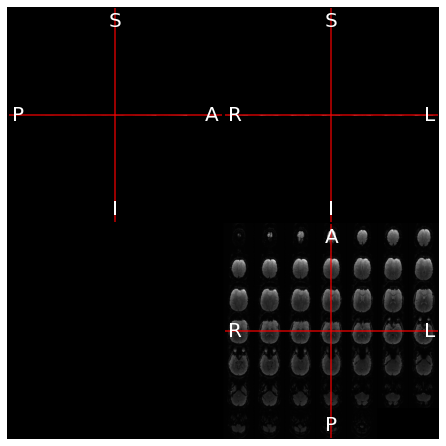

In [51]:
im_func3d.plot_ortho()

not found: /data/aglinska/data/sfari_bids/ds-sfari-60/sub-001/func/sub-001_task-rest-ses-1.nii.gz


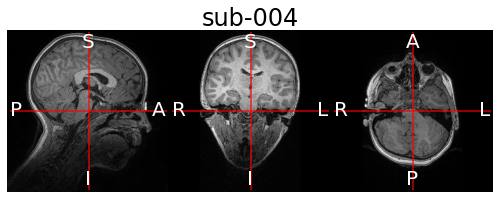

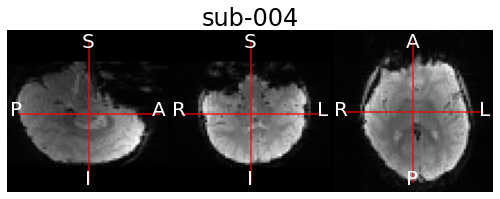

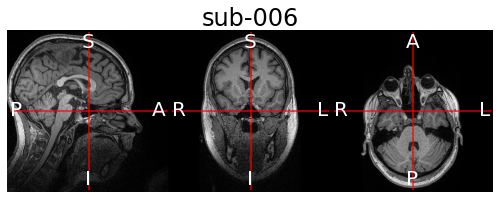

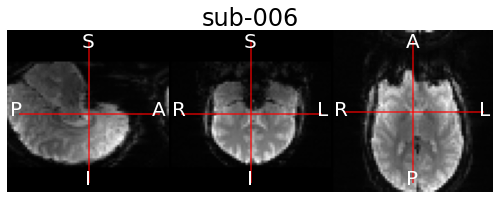

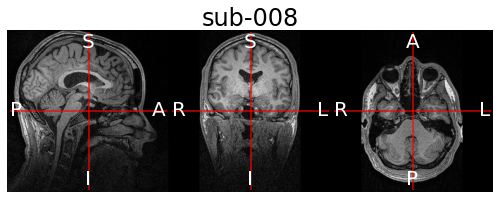

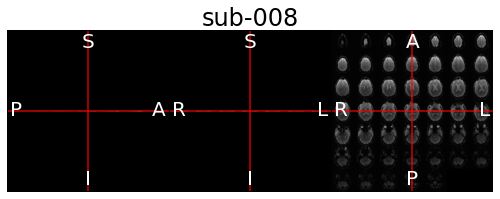

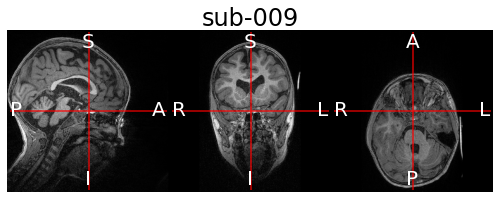

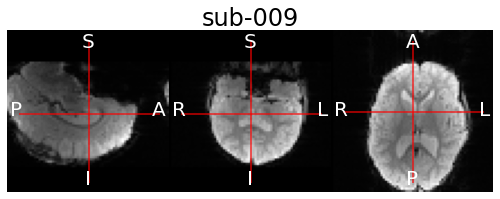

not found: /data/aglinska/data/sfari_bids/ds-sfari-60/sub-010/func/sub-010_task-rest-ses-1.nii.gz


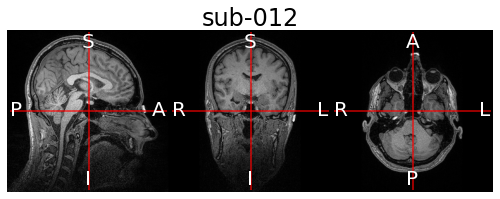

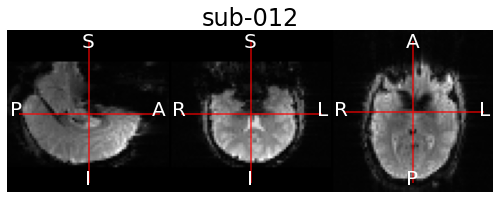

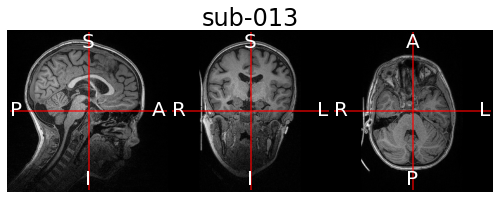

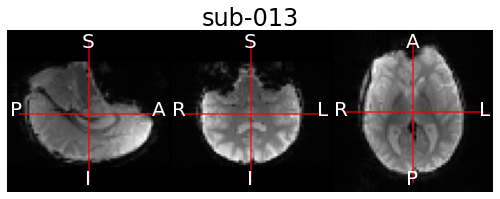

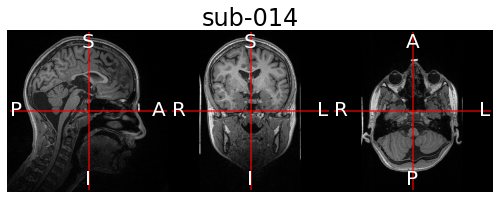

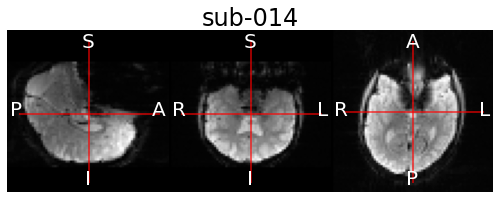

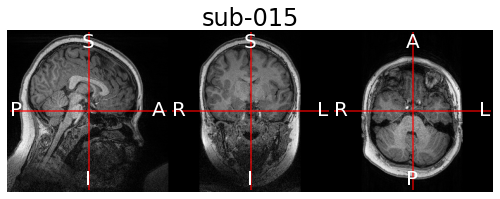

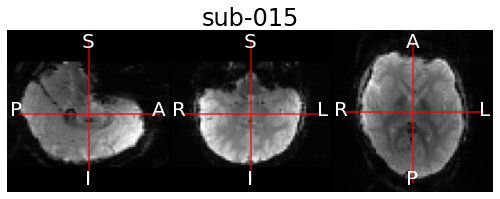

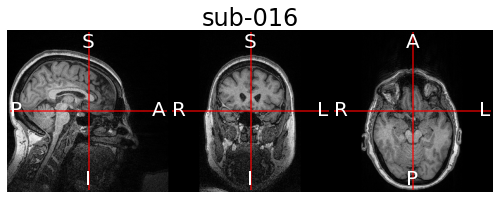

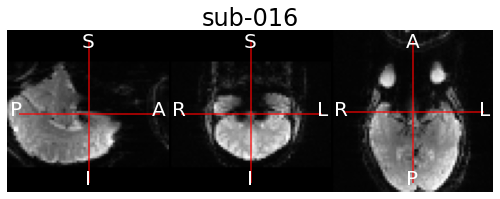

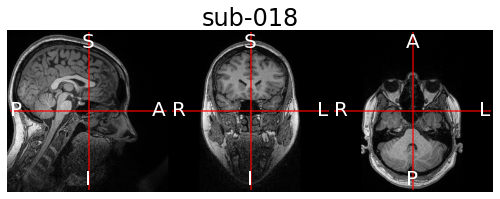

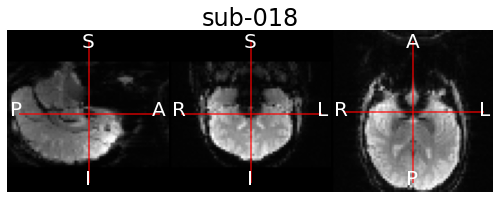

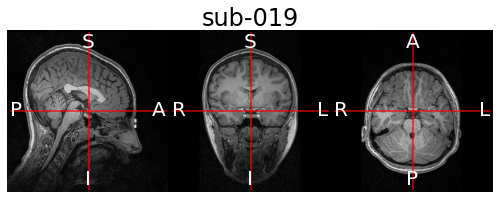

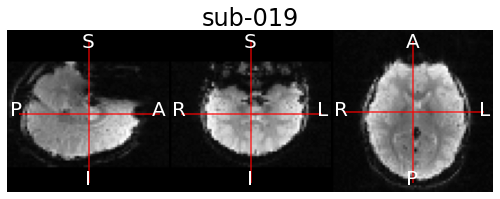

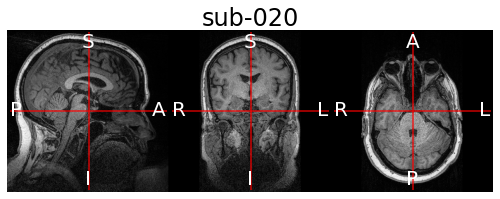

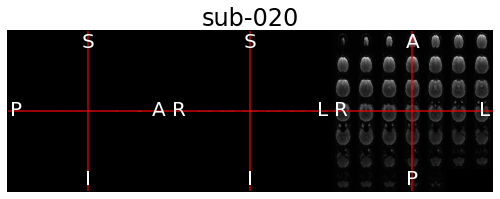

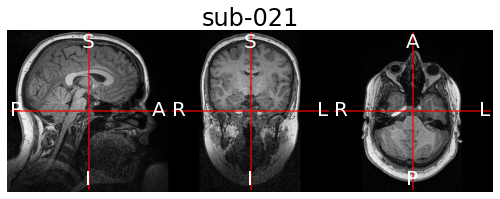

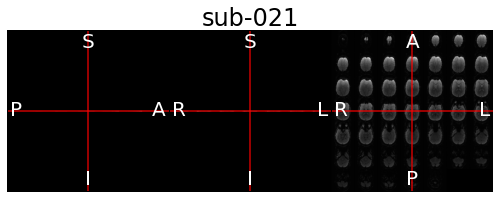

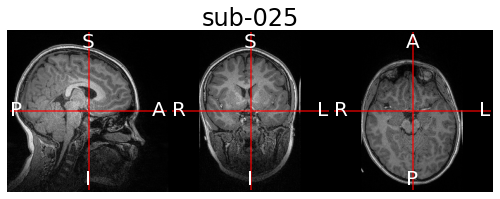

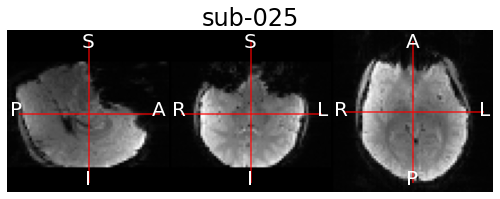

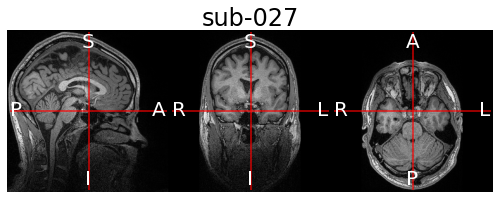

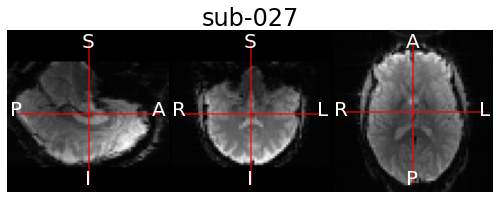

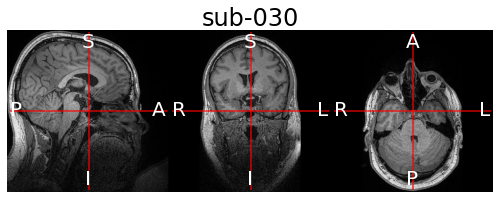

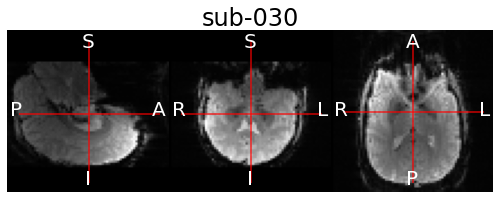

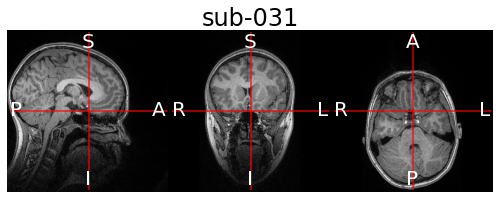

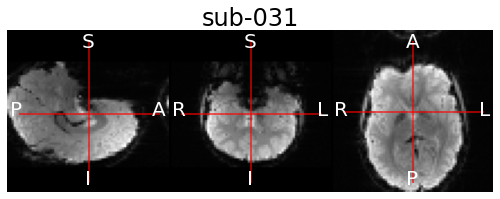

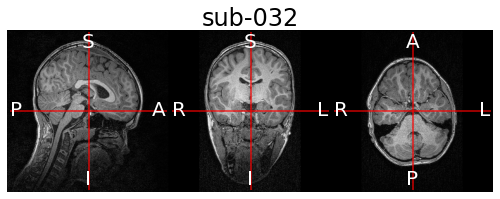

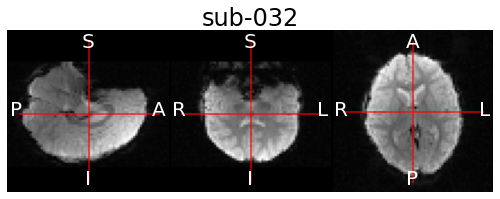

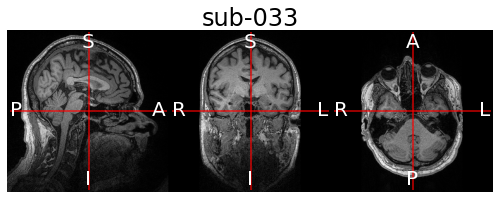

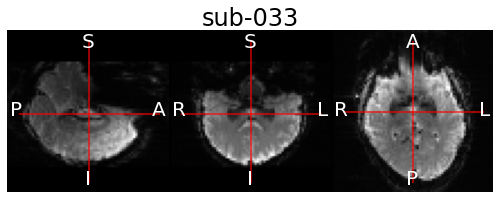

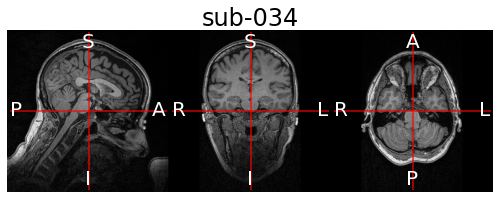

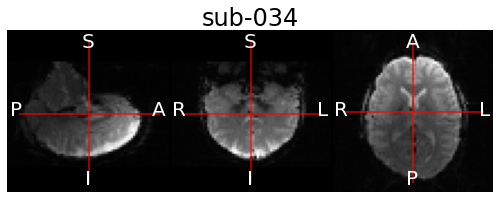

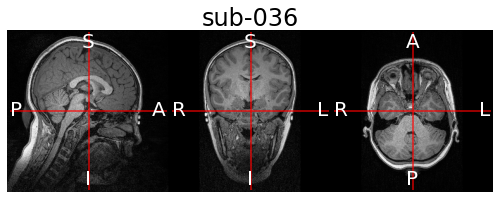

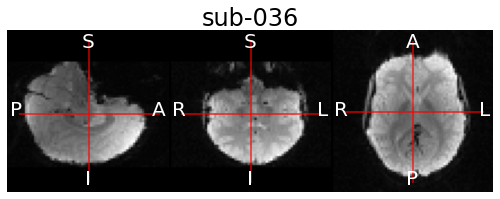

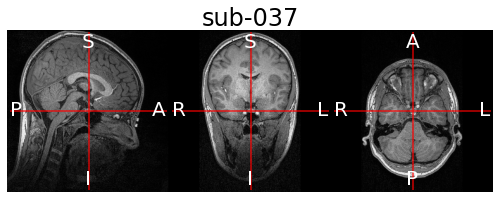

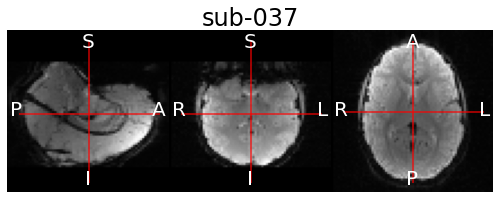

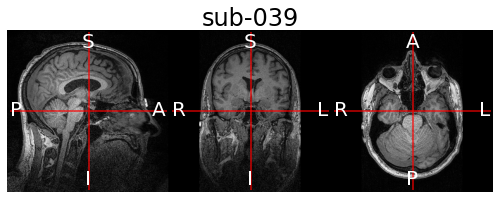

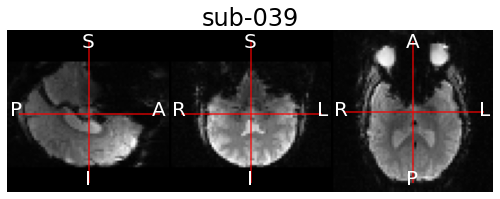

In [47]:
for s in range(25):
    sub = site_df['subID'].values[s]
    im_anat = ants.image_read(os.path.join(ds_dir,sub,'anat',f'{sub}_T1w.nii.gz'))
    
    if os.path.exists(os.path.join(ds_dir,sub,'func',f'{sub}_task-rest-ses-1.nii.gz')):
        im_func = ants.image_read(os.path.join(ds_dir,sub,'func',f'{sub}_task-rest-ses-1.nii.gz'))
        im_func = ants.slice_image(im_func,axis=3,idx=0)

        im_anat.plot_ortho(flat=True,title=sub)
        im_func.plot_ortho(flat=True,title=sub)
    else:
        print('not found: {}'.format(os.path.join(ds_dir,sub,'func',f'{sub}_task-rest-ses-1.nii.gz')))

In [15]:
# for idx,fn in enumerate(niis):
#     im = ants.image_read(os.path.join(sub_dir,fn))
#     if len(im.shape)==3:
#         im.plot_ortho(flat=True,title=fn)